# Content

1. **Introduction**: how does predicting insurance charges help companies?
2. **Data Cleaning & Exploratory Data Analysis**: clean data and understand trends for insurance charges based on different factors
3. **Modeling**: build linear regression model and fine tune to accurately predict insurance charges
4. **Conclusion**: summarize findings

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [55]:
# datasource: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset/data

df = pd.read_csv(r"C:\Users\annie\OneDrive\Documents\Annie Stuff\Grad School\Portfolio Project\insurance.csv")

In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Data Cleaning

In [62]:
# check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [60]:
# check null values

df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [61]:
# check duplicate values

df.duplicated().value_counts()

False    1337
Name: count, dtype: int64

In [59]:
# drop duplicate values

df.drop_duplicates(inplace=True)

# Exploratory Data Analysis

In [8]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


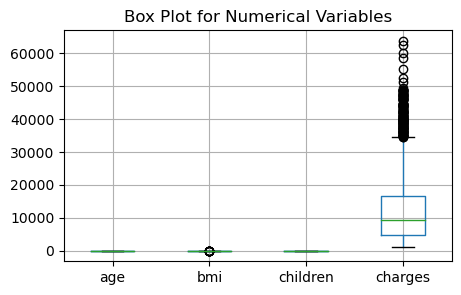

In [9]:
plt.figure(figsize=(5, 3))
df.boxplot(column=['age', 'bmi', 'children', 'charges'])
plt.title('Box Plot for Numerical Variables')
plt.show()

### Charges by Region

Southeast region seems to have higher charges than the rest of the regions.

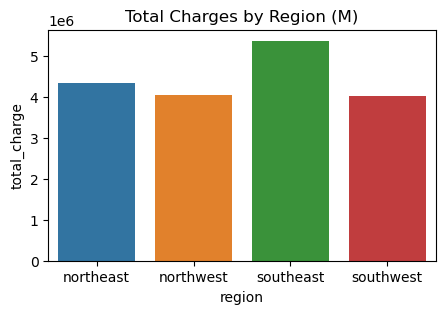

In [10]:
region_charge = df.groupby('region')['charges'].sum().reset_index(name='total_charge')

plt.figure(figsize=(5, 3))
sns.barplot(x='region', y='total_charge', data=region_charge)
plt.title('Total Charges by Region (M)')
plt.show()

### Smoker Details

While Southeast region has highest charges, smokers in the southeast also contributes to charges more than the non-smokers.

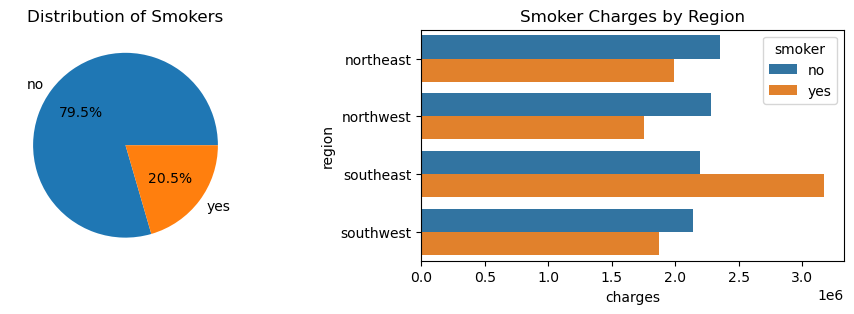

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

smoker_count = df.groupby('smoker').size()
smoker_region = df.groupby(['region', 'smoker'])['charges'].sum().reset_index()

axs[0].pie(smoker_count, labels=smoker_count.index, autopct='%1.1f%%')
axs[0].set_title('Distribution of Smokers')

sns.barplot(x='charges', y='region', hue='smoker', data=smoker_region, orient='h', ax=axs[1])
plt.title('Smoker Charges by Region')
plt.show()

### Children Details

There is an inverse relationship between number of children and charges.

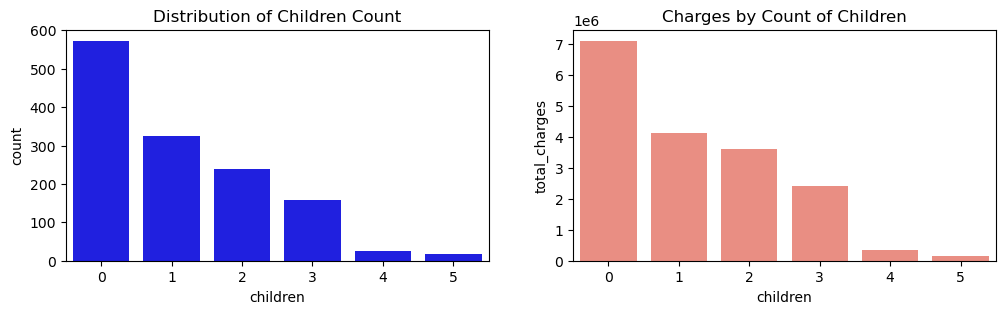

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

children_spread = df.groupby('children').size().reset_index(name='count')
children_charges = df.groupby('children')['charges'].sum().reset_index(name='total_charges')

sns.barplot(x='children', y='count', data=children_spread, ax=axs[0], color='blue')
axs[0].set_title('Distribution of Children Count')

sns.barplot(x='children', y='total_charges', data=children_charges, ax=axs[1], color='salmon')
axs[1].set_title('Charges by Count of Children')

plt.show()

### Gender Details

There is an approximate equal amount of male and female. However, generally, male seems to have higher insurance charges, especially in the Southeast region.

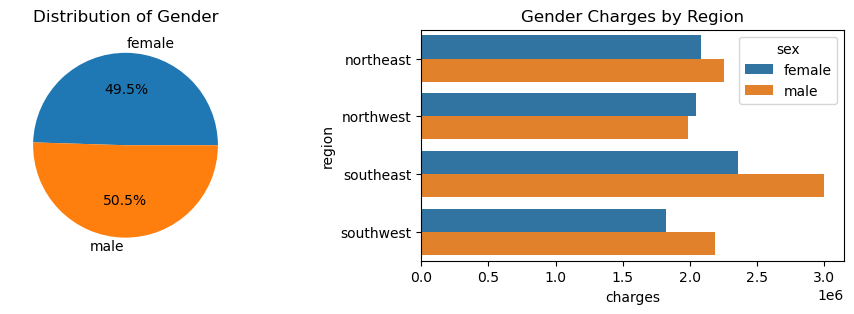

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

gender_count = df.groupby('sex').size()
gender_charges = df.groupby(['region', 'sex'])['charges'].sum().reset_index()

axs[0].pie(gender_count, labels=gender_count.index, autopct='%1.1f%%')
axs[0].set_title('Distribution of Gender')

sns.barplot(x='charges', y='region', hue='sex', data=gender_charges, orient='h', ax=axs[1])
plt.title('Gender Charges by Region')
plt.show()

### Age Distribution

Overall, there is a uniform distribution in regards to ages, except for a peak in kids less than 20 years old.

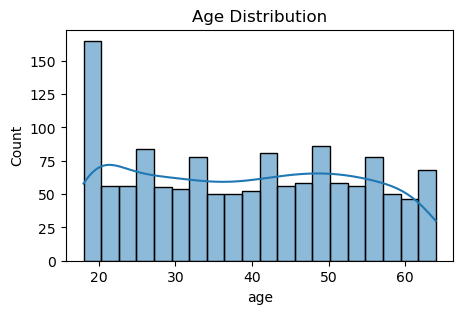

In [14]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

### BMI Distribution

BMI is normally distributed.

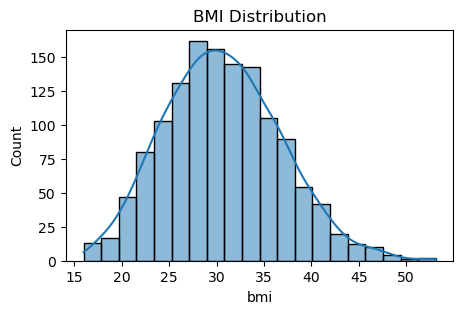

In [15]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df['bmi'], bins=20, kde=True)
plt.title('BMI Distribution')
plt.show()

# Modeling

In [20]:
# preparing data for modeling, feature engineering

df['sex'] = df['sex'].apply(lambda x: 0 if x=='male' else 1)
df['smoker'] = df['smoker'].apply(lambda x: 0 if x=='no' else 1)
df['northeast'] = df['region'].apply(lambda x: 1 if x=='northeast' else 0)
df['northwest'] = df['region'].apply(lambda x: 1 if x=='northwest' else 0)
df['southeast'] = df['region'].apply(lambda x: 1 if x=='southeast' else 0)
df['southwest'] = df['region'].apply(lambda x: 1 if x=='southwest' else 0)

In [22]:
df.drop('region', axis=1, inplace=True)

In [25]:
# split the data into training and validation sets

X = df.drop('charges', axis=1)  # features
y = df['charges']  # target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
quant_var = df[['age', 'bmi', 'children', 'charges']]
corr_matrix = quant_var.corr()
corr_matrix

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


In [46]:
# train a linear regression model on the training set
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     358.1
Date:                Sun, 19 May 2024   Prob (F-statistic):          4.94e-295
Time:                        21:05:56   Log-Likelihood:                -10831.
No. Observations:                1069   AIC:                         2.168e+04
Df Residuals:                    1060   BIC:                         2.172e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          248.2107     13.507     18.376      0.0

In [63]:
# check for multicollinearity

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

[3.858552420449628e-06, 0.003018816596508984, 2.22594036726693e-05, 0.0005170691615026256, 0.004645910151892904, 0.027202617321364583, 0.027288407740772458, 0.03236918864039377, 0.029045304939453103]


In [47]:
# build another regression with statistically significant variables

X_train = df.drop(['charges', 'sex'], axis=1)  # features
y_train = df['charges']  # target variable

model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     571.8
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        21:06:26   Log-Likelihood:                -13538.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1329   BIC:                         2.713e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          256.8751     11.905     21.577      0.0

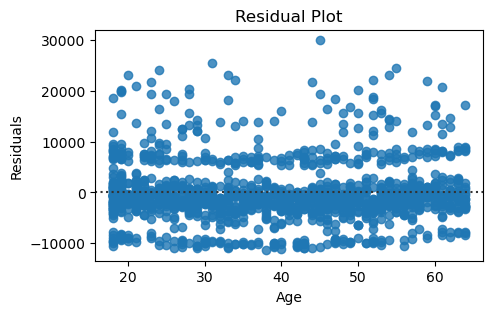

In [50]:
# Get the residuals
residuals = model.resid

# Create a residual plot
plt.figure(figsize=(5, 3))
sns.residplot(x=X_train['age'], y=residuals)
plt.title('Residual Plot')
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.show()

## Conclusion

Overall, this model has an adjusted R-squared of 0.75, which is a decent model to predict for insurance charges. Furthermore, this model is statistically significant with smoker having the largest coefficient, which is the factor that contributes most to insurance charges. It is important for insurance companies to correctly predict insurance costs in order to drive efficiency and enable strategic planning.